In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
# reloads imports (utils) if something changes
%load_ext autoreload
%autoreload 2

In [14]:
# replace and redo previoulsy processed data = True, else = False
Replace = True

In [58]:
#Set paths 
Animal_ID = ['EJT262']
#'EJT149','EJT162','EJT178',

InputPath = (r'Z:\projects\sequence_squad\data\raw_bpod')
CameraPath = (r'Z:\projects\sequence_squad\data\video_data\raw_flycap')

OutputPath = (r'Z:\projects\sequence_squad\data\processed_bpod_data')



In [59]:
## import functions from .py utils file: 
from Utilities.preprocessing import *

In [60]:
def FindEphysTimestamps(filedate,CameraPath,CurrentAnimal):
    
    file_date = filedate[6:8] + filedate[4:6] + filedate[2:4]

    TimeStampsExist = False
    TimeStampPaths = []
    Camera_started_after = 'n/a'
    

    path_ = CameraPath + '\\' + CurrentAnimal

    if os.path.isdir(path_):
        Dirs = sorted(os.listdir(path_))
        if file_date in Dirs:
            sub_dir = (os.listdir(path_+'\\'+ file_date))
            for session_dir in sub_dir:
                if 'clock' in session_dir:
                    files = sorted(os.listdir(os.path.join(path_,file_date ,session_dir)))
                    for file in files:
                        if file[-2] == 's': #if its a .csv and not a avi
                            if file != '.DS_Store': #if file is not the weird hidden file 
                                if len(file) > 10: # crapy hacky way to determine if metadata saved in filename or not 
                                    camerafiletime = file[-12:-4].replace("_", "")
                                    if int(camerafiletime) < int(filedate[9:15]):   
                                        TimeStampsExist = True
                                        TimeStampPaths = TimeStampPaths + [os.path.join(path_,file_date ,session_dir,file)]
                                        Camera_started_after = False
                                        print('timestamps found!')
                                    else:
                                        print('camera possibily started after behvaiour - accounted for')
                                        TimeStampsExist = True
                                        Camera_started_after = True
                                        TimeStampPaths = TimeStampPaths + [os.path.join(path_,file_date ,session_dir,file)]
                                else: #timestamp filename doesnt have metadata in it so we cant double check the starttime and have to assume it is fine : 
                                    print('error - filename has no metadata!')
    #                                 TimeStampsExist = True
    #                                 TimeStampPath = CameraPath + CurrentAnimal + '\\' + file_date + '\\' + file
                        
    return TimeStampsExist,Camera_started_after, TimeStampPaths


def find_first_poke_times(trial_id,All_Port_references_sorted,Trial_start_ts):
    first_poke_times= []
    counter = 0 
    for index,item in enumerate(trial_id):
        if All_Port_references_sorted[index] == 2.0:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    first_poke_times = first_poke_times + [All_PortIn_Times_sorted[index]]
    return first_poke_times




# def test_timestamps_(first_poke_times,Trial_start_ts,Trial_start_Camera_Ts,First_poke_Camera_Ts):

#     try:
#         trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
#     except:
#         dropped_index = np.where(abs(np.diff(Trial_start_ts)-np.diff(Trial_start_Camera_Ts)) > 1)[0][0]
#         missing_trigger = Trial_start_Camera_Ts[dropped_index]+np.diff(Trial_start_ts)[dropped_index]
#         changed_camera_tria_start_ts = np.insert(Trial_start_Camera_Ts,dropped_index+1,[missing_trigger])

#         trial_start_difference = (np.diff(Trial_start_ts) - np.diff(changed_camera_tria_start_ts)[0:-1])
#         print('all good, there is no extra first poke TTL the end - ignored ')

#     for item in (trial_start_difference):
#         if abs(item) > 1:
#             raise NameError('Test not passed, Timestamps dont line up!')

#     try:
#         first_poke_difference = (np.diff(first_poke_times) - np.diff(First_poke_Camera_Ts)[0:-1])
#     except:
#         first_poke_difference = (np.diff(first_poke_times) - np.diff(First_poke_Camera_Ts))
#         dropped_index = np.where(abs(np.diff(first_poke_times)-np.diff(First_poke_Camera_Ts)) > 1)[0][0]
#         missing_trigger = First_poke_Camera_Ts[dropped_index]+np.diff(first_poke_times)[dropped_index]
#         changed_camera_firstpoke_ts = np.insert(First_poke_Camera_Ts,dropped_index+1,[missing_trigger])
#         print('weird first poke dropped ts fix')

#         first_poke_difference = (np.diff(first_poke_times) - np.diff(changed_camera_firstpoke_ts[0:-1]))

#     for item in (first_poke_difference):
#         if abs(item) > 1:
#             raise NameError('Test not passed, Timestamps dont line up!')
    
#     print('test passed!')
    
def process_camera_data(TimeStampPath,Trial_start_ts,trial_id,trialstart_index,All_Port_references_sorted,Trial_end_ts,Save_path,seqs):

    #Load camera timestamps:
    Camera_ts_raw = load_camera_timestamps(TimeStampPath)
    #Convert to seconds and uncycle:
    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)

    #pull out video name
    video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            'DataPath': ([TimeStampPath] * len(Camera_ts))})

        #Save Data
        Camera_dataframe.to_csv(Save_path + '//' + video_name[0] + '.csv')


        #find camera inds that align with trigger start and stop events (trial start and first poke):
        Trial_start_camera_inds,Poke1_camera_inds = Find_TrialStart_and_Poke1_camera_inds(Camera_trig_states)

        # check that camera timestamps are correct: 
        first_poke_times = clock_find_first_poke_times(trial_id,All_Port_references_sorted,Trial_start_ts,trial_types,seqs)
        Trial_start_Camera_Ts, First_poke_Camera_Ts = test_timestamps_(first_poke_times,Trial_start_ts,Camera_ts[Trial_start_camera_inds],Camera_ts[Poke1_camera_inds])

        #align behavioural data (trial starts) with camera timestamps 
        Trial_start_Camera_Ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_start_Camera_Ts)
        #align behavioural data (trial ends) with camera timestamps 
        Trial_end_Camera_Ts_aligned = new_generate_aligned_trial_end_camera_ts(Trial_start_Camera_Ts,Trial_end_ts,Trial_start_ts,trial_id,trialstart_index)
        #align behavioural data (first poke in port1) with camera timestamps 
        First_poke_Camera_Ts_aligned = clock_align_firstpoke_camera_timestamps(trial_id,trialstart_index,First_poke_Camera_Ts,All_Port_references_sorted,seqs,trial_types)

    else:
        print('Triggers Broken')
        TimeStampsExist = False
        Trial_start_Camera_Ts_aligned = ['NaN'] * len(trial_id)
        Trial_end_Camera_Ts_aligned = ['NaN'] * len(trial_id)
        First_poke_Camera_Ts_aligned = ['NaN'] * len(trial_id)


    return Trial_start_camera_inds, Trial_start_Camera_Ts_aligned, Trial_end_Camera_Ts_aligned, First_poke_Camera_Ts_aligned,video_name 


def Find_TrialStart_and_Poke1_camera_inds(Camera_trig_states):

    where_ttl_changes = list(np.where(np.roll(Camera_trig_states,1)!=Camera_trig_states)[0])
    if where_ttl_changes[0] == 0:
        where_ttl_changes = where_ttl_changes[1::]
    Poke1_camera_inds = where_ttl_changes[1::2]
    Trial_start_camera_inds= where_ttl_changes[0::2]

    return Trial_start_camera_inds, Poke1_camera_inds   

def new_generate_aligned_trial_end_camera_ts(Trial_start_Camera_Ts,Trial_end_ts,Trial_start_ts,trial_id,trialstart_index):
    trial_len = np.array(Trial_end_ts) - np.array(Trial_start_ts)
    trial_end_camera_ts = Trial_start_Camera_Ts[0:-1] + trial_len
    aligned_trial_end_camera_ts = align_trial_start_end_timestamps(trial_id,trialstart_index,trial_end_camera_ts)
    return aligned_trial_end_camera_ts

In [61]:
def test_timestamps_(first_poke_times,Trial_start_ts,Trial_start_Camera_Ts,First_poke_Camera_Ts):
    working = False
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
        working = True

    except:
        print('broken - being fixed')
        tester = False
        while tester == False:
            Trial_start_Camera_Ts,tester = fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts)
            print('fixed')
        print('all fixed')
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
        working = True
        print('working')
    except:
        print('fail')

    for item in (trial_start_difference):
        if abs(item) > 1:
            raise NameError('Test not passed, Timestamps dont line up!')

    # do the same for first pokes: 
    
    working = False
    try:
        first_poke_difference = (np.diff(first_poke_times) - np.diff(First_poke_Camera_Ts)[0:-1])
        working = True

    except:
        print('broken - being fixed')
        tester = False
        while tester == False:
            First_poke_Camera_Ts,tester = fix_missing_triggers(first_poke_times,First_poke_Camera_Ts)
            print('fixed')
        print('all fixed')
    try:
        first_poke_difference = (np.diff(first_poke_times) - np.diff(First_poke_Camera_Ts)[0:-1])
        working = True
        print('working')
    except:
        print('fail')

    plt.plot(first_poke_difference)
    for item in (first_poke_difference):
        if abs(item) > 1:
            raise NameError('Test not passed, Timestamps dont line up!')


    print('test passed!')
    
    Trial_start_Camera_Ts= Trial_start_Camera_Ts
    First_poke_Camera_Ts = First_poke_Camera_Ts
    
    return Trial_start_Camera_Ts, First_poke_Camera_Ts


    
    
    # working = False
# for i in range(100):
#     try:
#         trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
#         working = True
#     except:
#         Trial_start_Camera_Ts = fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts)
#         print('fixed')
        
#     if working == True:
#         print('working')
#         break

        
        
        
        

def fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts):

    fixed_trial_strart_ts= []
    for index,item in enumerate(np.diff(Trial_start_ts)):
        if abs(item - np.diff(Trial_start_Camera_Ts)[index]) > 1:
            missing_trigger = Trial_start_Camera_Ts[index]+np.diff(Trial_start_ts)[index]
            fixed_trial_strart_ts = np.insert(Trial_start_Camera_Ts,index+1,[missing_trigger])
            break
    
    try:
        trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
        for item in (trial_start_difference):
            if abs(item) > 1:
                tester = False
            else:
                tester = True
                fixed_trial_strart_ts = Trial_start_Camera_Ts
    except:
        tester = False

            
    return fixed_trial_strart_ts, tester


def clock_find_first_poke_times(trial_id,All_Port_references_sorted,Trial_start_ts,trial_types,seqs):

    first_poke_times= []
    counter = 0 
    for index,item in enumerate(trial_id):
        trial_type = trial_types[item-1]
        if All_Port_references_sorted[index] == seqs[trial_type-1][0]:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    first_poke_times = first_poke_times + [All_PortIn_Times_sorted[0][index]]
    return first_poke_times


In [62]:
def clock_align_firstpoke_camera_timestamps(trial_id,trialstart_index,Trial_start_ts,All_Port_references_sorted,seqs,trial_types):
    counter = 0
    trial_ts_aligned = []
    for index,item in enumerate(trial_id):
        trial_type = trial_types[item-1]
        if All_Port_references_sorted[index] ==  seqs[trial_type-1][0]:
            if item > counter:
                counter = counter + 1
                #getting an error 05/01/22 -> I think if the next trial started (TTL went high) but no poke was recorded then there wont be a poke timestamp so account for this: 
                if not len(Trial_start_ts) == counter - 1:
                    trial_ts_aligned = trial_ts_aligned + [Trial_start_ts[counter-1]]
                else:
                    trial_ts_aligned = trial_ts_aligned + ['NaN']
            else:
                trial_ts_aligned = trial_ts_aligned + ['NaN']
        else:
            trial_ts_aligned = trial_ts_aligned + ['NaN']
    return trial_ts_aligned


In [63]:
def clock_find_reward_inds(All_PortIn_Times_sorted,All_Port_references_sorted,Reward_ts,seqs,trial_types,trial_id):
    Rewarded_events = []
    counter = 0
    for index,ports in enumerate(All_Port_references_sorted):
        trial_type = trial_types[trial_id[index]-1]
        if ports == seqs[trial_type-1][-1]:
            if counter < len(Reward_ts):
                if np.isnan(Reward_ts[counter]):
                    counter = counter + 1
                if counter < len(Reward_ts):
                    if  All_PortIn_Times_sorted[index] >= Reward_ts[counter]:
                        Rewarded_events = Rewarded_events + [index]
                        counter = counter + 1
    return(Rewarded_events)

# MAIN:

Processing data for: EJT262
EJT262_ClockTask_20230524_161235.mat
timestamps found!
timestamps found!
timestamps found!
Z:\projects\sequence_squad\data\video_data\raw_flycap\EJT262\240523\4_clock\back_2023-05-24T16_11_38.csv
Frames dropped = 1
broken - being fixed
fixed
fixed
all fixed
working
broken - being fixed
fixed
fixed
all fixed
working
test passed!
Z:\projects\sequence_squad\data\video_data\raw_flycap\EJT262\240523\4_clock\camera2_2023-05-24T16_11_38.csv
Frames dropped = 3
broken - being fixed
fixed
fixed
all fixed
working
broken - being fixed
fixed
fixed
all fixed
working
test passed!
Z:\projects\sequence_squad\data\video_data\raw_flycap\EJT262\240523\4_clock\side_2023-05-24T16_11_39.csv
Frames dropped = 0
broken - being fixed
fixed
fixed
all fixed
working
broken - being fixed
fixed
fixed
all fixed
working
test passed!
done


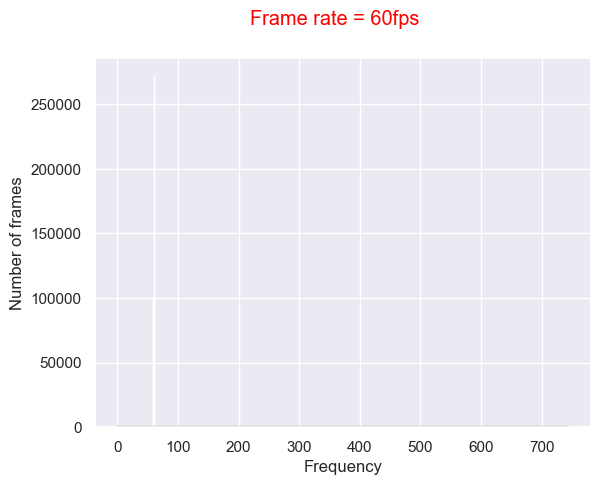

In [64]:
#### MAIN ####
for Animal_index, CurrentAnimal in enumerate(Animal_ID):
    print ('Processing data for: ' + CurrentAnimal)
    InputPathCurrent = os.path.join(InputPath,CurrentAnimal,'clock_task') + '\\' 
    

    #Load Behavioural data:
    Behav_data, Sessions,Path,FileDates = Import_Bpod_DataFiles(InputPathCurrent)
    
    Processed = ('')
    Skipped = ('')

#     for Session in range(2,Sessions):
    for Session in range(Sessions):

        
        filedate = FileDates[Session] + '_' + str(Behav_data[Session]['__header__'])[-25:-22]

        if Session < 10:
            Save_path = (OutputPath + '\\'+ CurrentAnimal + '\Preprocessed' + '\\'  + 'CLOCK_' + filedate + '\\')
        else:
            Save_path = (OutputPath + '\\' + CurrentAnimal + '\Preprocessed' + '\\'  + 'CLOCK_' + filedate + '\\')

        # see if dir exists already then use bool logic to detemrine if it needs to be processed or not
        if not os.path.isdir(Save_path):
            os.makedirs(Save_path)
            Process = True
        else:
            if  Replace == True:
                Process = True
            else:
                Process = False

        if  Process == True:

            #Convert to python friendly format:
            convert_nested_structs(Behav_data[Session])
            
            #extract trial types
            trial_types = Behav_data[Session]['SessionData']['TrialTypes']
            
            #Extract PortIn times for each port and check for errors (inside this function):
            All_PortIn_Times,All_PortOut_Times,All_Port_references = extract_poke_times(Behav_data[Session])

            #remove nans (times when part [in or out poke] of the event was dropped for some reason by bpod)
            All_PortIn_Times_fixed,All_PortOut_Times_fixed ,All_Port_references_fixed = remove_dropped_in_events(All_PortIn_Times,All_PortOut_Times,All_Port_references)
            
            # Resort these in time:
            All_PortIn_Times_sorted,All_PortOut_Times_sorted,All_Port_references_sorted = time_sort(All_PortIn_Times,All_PortOut_Times,All_Port_references)

            #extract trial start time stamps
            Trial_start_ts = extract_trial_timestamps(Behav_data[Session])

            #extract trial end times:
            Trial_end_ts = extract_trial_end_times(Behav_data[Session])

            #determine trial IDs
            trial_id = determine_trial_id(All_PortIn_Times_sorted[0],Trial_end_ts)
            
            #extract reward times:
            Reward_ts = extract_reward_times(Behav_data[Session])
            
            ## seqs in the clock sequence
            Trial_settings = todict(Behav_data[Session]['SessionData']['TrialSettings'][0])
            seqs = []
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence1'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence2'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence3'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence4'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence5'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence6'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence7'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence8'])]
            seqs = seqs  + [list(Trial_settings['GUI']['Sequence9'])]


            # find reward inds and align rewarded ts to poke events:
            Rewarded_event_inds = clock_find_reward_inds(All_PortIn_Times_sorted[0],All_Port_references_sorted[0],Reward_ts,seqs,trial_types,trial_id)
            Reward_ts = np.asarray(Reward_ts)
            Reward_ts = Reward_ts[np.logical_not(np.isnan(Reward_ts))]
            Reward_ts = list(Reward_ts)
            Reward_ts_aligned = align_trigger_to_index(Reward_ts,Rewarded_event_inds,All_Port_references_sorted[0])


            # align trial start and end times to poke events
            trialstart_index = find_trialstart_index(trial_id)
            trial_start_ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_start_ts)
            trial_end_ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_end_ts)
            
            
            #Search for timestamps for given animal and session 
            TimeStampsExist,Camera_started_after, TimeStampPaths = FindEphysTimestamps(filedate,CameraPath,CurrentAnimal)
            
            if TimeStampsExist:
                #process camera data:
                for index, TimeStampPath in enumerate(TimeStampPaths):
                    print(TimeStampPath)
                    
                    if index == 0:
                        Trial_start_camera_inds, Trial_start_Camera_Ts_aligned, Trial_end_Camera_Ts_aligned, First_poke_Camera_Ts_aligned,video_name  = process_camera_data(TimeStampPath,Trial_start_ts,trial_id,trialstart_index,All_Port_references_sorted[0],Trial_end_ts,Save_path,seqs)
                    elif index == 1:
                        out1,out2,out3,out4,out5  = process_camera_data(TimeStampPath,Trial_start_ts,trial_id,trialstart_index,All_Port_references_sorted[0],Trial_end_ts,Save_path,seqs)
                        Trial_start_camera_inds = [Trial_start_camera_inds] + [out1]
                        Trial_start_Camera_Ts_aligned = [Trial_start_Camera_Ts_aligned] + [out2]
                        Trial_end_Camera_Ts_aligned = [Trial_end_Camera_Ts_aligned] + [out3]
                        First_poke_Camera_Ts_aligned = [First_poke_Camera_Ts_aligned] + [out4]
                        video_name = [video_name] + [out5]
                    else:
                        out1,out2,out3,out4,out5  = process_camera_data(TimeStampPath,Trial_start_ts,trial_id,trialstart_index,All_Port_references_sorted[0],Trial_end_ts,Save_path,seqs)
                        Trial_start_camera_inds.append(out1)
                        Trial_start_Camera_Ts_aligned.append(out2)
                        Trial_end_Camera_Ts_aligned.append(out3) 
                        First_poke_Camera_Ts_aligned.append(out4)
                        video_name.append(out5)
                        
            else:
                Trial_start_Camera_Ts_aligned = ['Cameras Corrupted  no video data'] * len(trial_id)
                Trial_end_Camera_Ts_aligned = ['Cameras Corrupted  no video data'] * len(trial_id)
                First_poke_Camera_Ts_aligned = ['Cameras Corrupted  no video data'] * len(trial_id)
          

      
               
            # align trial sequences (trial types)
            Trial_seq = []
            counter = 1
            for index,item in enumerate(trial_id):
                if counter == item:
                    Trial_seq = Trial_seq + [seqs[trial_types[counter-1]-1]]
                else:
                    counter = counter + 1
                    Trial_seq = Trial_seq + [seqs[trial_types[counter-1]-1]]

        
            # make portin dataframe:
            PortIn_df = pd.DataFrame(
                {'Trial_id' : trial_id,
                 'Trial_sequence': Trial_seq,
                 'Trial_Start' : trial_start_ts_aligned,
                 'Port': All_Port_references_sorted[0],
                 'PokeIn_Time': All_PortIn_Times_sorted[0],
                 'PokeOut_Time': All_PortOut_Times_sorted[0],
                 'Reward_Times': Reward_ts_aligned,
                 'Trial_End' : trial_end_ts_aligned})

            for index, item in enumerate(video_name):
                if 'back' in item[0]:
                    PortIn_df['BACK_Trial_Start_Camera_Time'] = Trial_start_Camera_Ts_aligned[index]
                    PortIn_df['BACK_Trial_End_Camera_Time'] = Trial_end_Camera_Ts_aligned[index]
                    PortIn_df['BACK_First_poke_Camera_Time'] = First_poke_Camera_Ts_aligned[index]
                if 'side' in item[0]:
                    PortIn_df['SIDE_Trial_Start_Camera_Time'] = Trial_start_Camera_Ts_aligned[index]
                    PortIn_df['SIDE_Trial_End_Camera_Time'] = Trial_end_Camera_Ts_aligned[index]
                    PortIn_df['SIDE_First_poke_Camera_Time'] = First_poke_Camera_Ts_aligned[index]
                if 'bottom' in item[0]:
                    PortIn_df['BOTTOM_Trial_Start_Camera_Time'] = Trial_start_Camera_Ts_aligned[index]
                    PortIn_df['BOTTOM_Trial_End_Camera_Time'] = Trial_end_Camera_Ts_aligned[index]
                    PortIn_df['BOTTOM_First_poke_Camera_Time'] = First_poke_Camera_Ts_aligned[index]

            #Save Data
            PortIn_df.to_csv(Save_path +'/PreProcessed_RawPokeData.csv')
            
            print('done')
                        

            

In [50]:
PortIn_df

,Trial_id,Trial_sequence,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,BACK_Trial_Start_Camera_Time,BACK_Trial_End_Camera_Time,BACK_First_poke_Camera_Time,SIDE_Trial_Start_Camera_Time,SIDE_Trial_End_Camera_Time,SIDE_First_poke_Camera_Time
0,1,"[1, 5]",12.3797,1,31.5866,31.6274,NaN,63.6005,49.076750,100.297550,68.284375,49.076625,100.297425,68.284125
1,1,"[1, 5]",12.3797,1,31.7040,31.7456,NaN,63.6005,49.076750,100.297550,NaN,49.076625,100.297425,NaN
2,1,"[1, 5]",12.3797,1,31.7610,31.8915,NaN,63.6005,49.076750,100.297550,NaN,49.076625,100.297425,NaN
3,1,"[1, 5]",12.3797,2,50.7052,50.7389,NaN,63.6005,49.076750,100.297550,NaN,49.076625,100.297425,NaN
4,1,"[1, 5]",12.3797,7,53.4165,53.4179,NaN,63.6005,49.076750,100.297550,NaN,49.076625,100.297425,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4342,868,"[2, 5]",7201.5759,1,7246.1279,7246.2373,NaN,7253.3376,7238.912375,7290.674075,NaN,7238.925750,7290.687450,NaN
4343,868,"[2, 5]",7201.5759,2,7246.7343,7246.8051,NaN,7253.3376,7238.912375,7290.674075,7284.074375,7238.925750,7290.687450,7284.087625
4344,868,"[2, 5]",7201.5759,2,7246.8497,7247.7314,NaN,7253.3376,7238.912375,7290.674075,NaN,7238.925750,7290.687450,NaN
4345,868,"[2, 5]",7201.5759,6,7251.0808,7251.2090,NaN,7253.3376,7238.912375,7290.674075,NaN,7238.925750,7290.687450,NaN


In [19]:
seqs

[[1, 5], [1, 6], [2, 1], [2, 5], [2, 6], [2, 7], [2, 3], [3, 6], [3, 7]]

In [180]:
trial_types[index]

IndexError: index 673 is out of bounds for axis 0 with size 672

In [207]:
trial_types

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,

In [194]:
Trial_seq

[[1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 5],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 [1, 6],
 

In [193]:
Trial_seq = []
counter = 1
for index,item in enumerate(trial_id):
    if counter == item:
        Trial_seq = Trial_seq + [seqs[trial_types[counter-1]-1]]
    else:
        counter = counter + 1
        Trial_seq = Trial_seq + [seqs[trial_types[counter-1]-1]]
        

In [167]:
trial_types

seqs[Trial_seq[index]]

NameError: name 'Trial_seq' is not defined

In [161]:
PortIn_df

,Trial_id,Trial_Start,Port,PokeIn_Time,PokeOut_Time,Reward_Times,Trial_End,BACK_Trial_Start_Camera_Time,BACK_Trial_End_Camera_Time,BACK_First_poke_Camera_Time,BOTTOM_Trial_Start_Camera_Time,BOTTOM_Trial_End_Camera_Time,BOTTOM_First_poke_Camera_Time,SIDE_Trial_Start_Camera_Time,SIDE_Trial_End_Camera_Time,SIDE_First_poke_Camera_Time
0,1,43.0649,6,70.8615,70.8798,NaN,116.8894,51.992125,125.816625,NaN,51.992000,125.816500,NaN,51.99175,125.81625,NaN
1,1,43.0649,6,75.6822,75.7364,NaN,116.8894,51.992125,125.816625,NaN,51.992000,125.816500,NaN,51.99175,125.81625,NaN
2,1,43.0649,6,75.7367,75.7372,NaN,116.8894,51.992125,125.816625,NaN,51.992000,125.816500,NaN,51.99175,125.81625,NaN
3,1,43.0649,5,77.1021,77.1290,NaN,116.8894,51.992125,125.816625,NaN,51.992000,125.816500,NaN,51.99175,125.81625,NaN
4,1,43.0649,2,109.7976,109.9994,NaN,116.8894,51.992125,125.816625,123.525,51.992000,125.816500,123.508125,51.99175,125.81625,123.52425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3028,671,3994.9779,6,4001.1863,4001.2116,NaN,4001.5976,4004.258875,4010.878575,NaN,4004.261375,4010.881075,NaN,4004.26800,4010.88770,NaN
3029,671,3994.9779,6,4001.3113,4002.3679,NaN,4001.5976,4004.258875,4010.878575,NaN,4004.261375,4010.881075,NaN,4004.26800,4010.88770,NaN
3030,672,4001.5978,2,4002.7446,4003.4878,NaN,4005.0680,4010.889000,4014.359200,4012.0385,4010.874875,4014.345075,4012.024375,4010.88150,4014.35170,4012.031
3031,672,4001.5978,6,4004.6567,4004.6683,NaN,4005.0680,4010.889000,4014.359200,NaN,4010.874875,4014.345075,NaN,4010.88150,4014.35170,NaN


Frames dropped = 4
working
working


NameError: Test not passed, Timestamps dont line up!

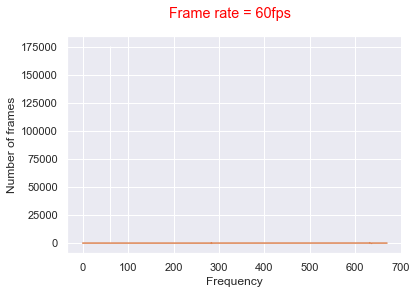

In [148]:
process_camera_data(TimeStampPath,Trial_start_ts,trial_id,trialstart_index,All_Port_references_sorted,Trial_end_ts,Save_path)

Frames dropped = 4
working
working
test passed!


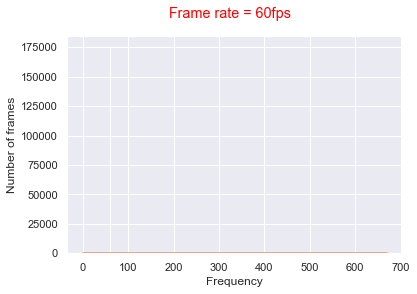

In [149]:
    #Load camera timestamps:
    Camera_ts_raw = load_camera_timestamps(TimeStampPath)
    #Convert to seconds and uncycle:
    Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

    #check for dropped frames:
    check_timestamps(Camera_ts, Frame_rate = 60)
    # Find triggers:
    Camera_trig_states = find_trigger_states(Camera_ts_raw)
    #check if triggers are working:
    result = np.max(Camera_trig_states) == np.min(Camera_trig_states)

    #pull out video name
    video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

    if not result:

        # make camera dataframe:
        Camera_dataframe = pd.DataFrame(
            {'Time Stamps': Camera_ts,
            'Trigger State': Camera_trig_states,
            'DataPath': ([TimeStampPath] * len(Camera_ts))})

        #Save Data
        Camera_dataframe.to_csv(Save_path + '//' + video_name[0] + '.csv')


    #find camera inds that align with trigger start and stop events (trial start and first poke):
    Trial_start_camera_inds,Poke1_camera_inds = Find_TrialStart_and_Poke1_camera_inds(Camera_trig_states)

    # check that camera timestamps are correct: 
    first_poke_times = clock_find_first_poke_times(trial_id,All_Port_references_sorted,Trial_start_ts,trial_types,seqs)
    Trial_start_Camera_Ts, First_poke_Camera_Ts = test_timestamps_(first_poke_times,Trial_start_ts,Camera_ts[Trial_start_camera_inds],Camera_ts[Poke1_camera_inds])

    #align behavioural data (trial starts) with camera timestamps 
    Trial_start_Camera_Ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_start_Camera_Ts)
    #align behavioural data (trial ends) with camera timestamps 
    Trial_end_Camera_Ts_aligned = new_generate_aligned_trial_end_camera_ts(Trial_start_Camera_Ts,Trial_end_ts,Trial_start_ts,trial_id,trialstart_index)
    #align behavioural data (first poke in port1) with camera timestamps 
    First_poke_Camera_Ts_aligned = align_firstpoke_camera_timestamps(trial_id,trialstart_index,First_poke_Camera_Ts,All_Port_references_sorted)


Frames dropped = 4
working
working
test passed!


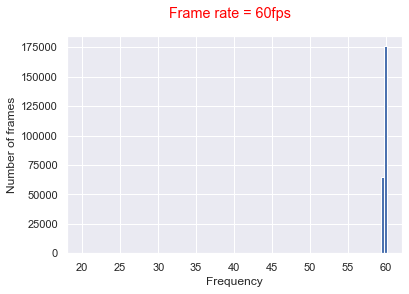

In [143]:
#Load camera timestamps:
Camera_ts_raw = load_camera_timestamps(TimeStampPath)
#Convert to seconds and uncycle:
Camera_ts = convert_uncycle_Timestamps(Camera_ts_raw)

#check for dropped frames:
check_timestamps(Camera_ts, Frame_rate = 60)
# Find triggers:
Camera_trig_states = find_trigger_states(Camera_ts_raw)
#check if triggers are working:
result = np.max(Camera_trig_states) == np.min(Camera_trig_states)

#pull out video name
video_name = [TimeStampPath.split("\\")[-1].split(".")[0] + '-camera-timestamp-data']

if not result:

    # make camera dataframe:
    Camera_dataframe = pd.DataFrame(
        {'Time Stamps': Camera_ts,
        'Trigger State': Camera_trig_states,
        'DataPath': ([TimeStampPath] * len(Camera_ts))})

    #Save Data
    Camera_dataframe.to_csv(Save_path + '//' + video_name[0] + '.csv')

#find camera inds that align with trigger start and stop events (trial start and first poke):
Trial_start_camera_inds,Poke1_camera_inds = Find_TrialStart_and_Poke1_camera_inds(Camera_trig_states)

# check that camera timestamps are correct: 
first_poke_times = clock_find_first_poke_times(trial_id,All_Port_references_sorted,Trial_start_ts,trial_types,seqs)

Trial_start_Camera_Ts, First_poke_Camera_Ts = test_timestamps_(first_poke_times,Trial_start_ts,Camera_ts[Trial_start_camera_inds],Camera_ts[Poke1_camera_inds])

# #align behavioural data (trial starts) with camera timestamps 
# Trial_start_Camera_Ts_aligned = align_trial_start_end_timestamps(trial_id,trialstart_index,Trial_start_Camera_Ts)
# #align behavioural data (trial ends) with camera timestamps 
# Trial_end_Camera_Ts_aligned = new_generate_aligned_trial_end_camera_ts(Trial_start_Camera_Ts,Trial_end_ts,Trial_start_ts,trial_id,trialstart_index)
# #align behavioural data (first poke in port1) with camera timestamps 
# First_poke_Camera_Ts_aligned = align_firstpoke_camera_timestamps(trial_id,trialstart_index,First_poke_Camera_Ts,All_Port_references_sorted)

In [97]:
first_poke_times,Trial_start_ts,Camera_ts[Trial_start_camera_inds],Camera_ts[Poke1_camera_inds]

5

In [136]:
Trial_start_Camera_Ts = Camera_ts[Trial_start_camera_inds]
First_poke_Camera_Ts = Camera_ts[Poke1_camera_inds]


In [142]:
working = False
try:
    trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
    working = True

except:
    print('broken - being fixed')
    tester = False
    while tester == False:
        Trial_start_Camera_Ts,tester = fix_missing_triggers(Trial_start_ts,Trial_start_Camera_Ts)
        print('fixed')
    print('all fixed')
try:
    trial_start_difference = (np.diff(Trial_start_ts) - np.diff(Trial_start_Camera_Ts)[0:-1])
    working = True
    print('working')
except:
    print('fail')

for item in (trial_start_difference):
    if abs(item) > 1:
        raise NameError('Test not passed, Timestamps dont line up!')

# do the same for first pokes: 

working = False
try:
    first_poke_difference = (np.diff(first_poke_times) - np.diff(First_poke_Camera_Ts)[0:-1])
    working = True

except:
    print('broken - being fixed')
    tester = False
    while tester == False:
        First_poke_Camera_Ts,tester = fix_missing_triggers(first_poke_times,First_poke_Camera_Ts)
        print('fixed')
    print('all fixed')
try:
    first_poke_difference = (np.diff(first_poke_times) - np.diff(First_poke_Camera_Ts)[0:-1])
    working = True
    print('working')
except:
    print('fail')

for item in (first_poke_difference):
    if abs(item) > 1:
        raise NameError('Test not passed, Timestamps dont line up!')


print('test passed!')

Trial_start_Camera_Ts= Trial_start_Camera_Ts
First_poke_Camera_Ts = First_poke_Camera_Ts



working
working
test passed!


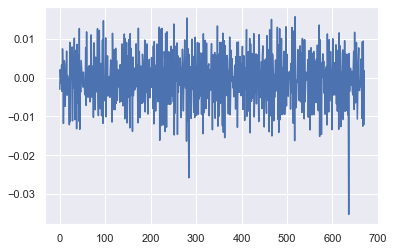

In [145]:
plt.plot(first_poke_difference)